In [1]:
# libraries
from operator import itemgetter
from IPython.display import display_html
from math import sqrt

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import folium
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data
london_flows = pd.read_csv("london_flows.csv")
london_flows.head(10)

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
5,Abbey Road,Crossharbour,1,599,1208,6686.475560
6,Abbey Road,Custom House,0,599,845,3824.855630
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909
8,Abbey Road,Cyprus,7,599,850,6532.099618
9,Abbey Road,Devons Road,1,599,611,3958.324171


In [4]:
#remove Battersea Park
london_flows = london_flows[
    (london_flows['station_origin'] != 'Battersea Park') &
    (london_flows['station_destination'] != 'Battersea Park')
]

In [5]:
#now chop out the intra-borough flows
london_flows = london_flows[(london_flows['station_origin'] != london_flows['station_destination'])]

In [6]:
london_flows['log_dest_jobs'] = np.log(london_flows['jobs'])
london_flows['log_distance'] = np.log(london_flows['distance'])

In [7]:
london_flows

,station_origin,station_destination,flows,population,jobs,distance,log_dest_jobs,log_distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274
...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.114325,9.503144
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.610137,9.071245
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,5.991465,9.162905
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,6.794587,8.585832


In [8]:
# define functions
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [9]:
london_flows_matrix = pd.pivot_table(london_flows, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

london_flows_matrix

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [10]:
#Production-constrained Model-inverse

#create the formula (the "-1" indicates no intercept in the regression model).
formula1 = 'flows ~ station_origin + log_dest_jobs + log_distance-1'
#run a production constrained sim
Sim1 = smf.glm(formula = formula1, data=london_flows, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(Sim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Mon, 29 Apr 2024   Deviance:                   1.8615e+06
Time:                        17:45:59   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [11]:
london_flows["fit1"] = np.round(Sim1.mu,0)

#Summary Statistics
print("RSquared =")
print(CalcRSquared(london_flows["flows"], london_flows["fit1"]))
print("RMSE =")
print(CalcRMSE(london_flows["flows"], london_flows["fit1"]))

RSquared =
0.3882763950178635
RMSE =
102.893


In [12]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula2 = 'flows ~ station_origin + log_dest_jobs + distance-1'
#run a production constrained sim
Sim2 = smf.glm(formula = formula2, data=london_flows, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(Sim2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Mon, 29 Apr 2024   Deviance:                   1.6477e+06
Time:                        17:47:33   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [13]:
london_flows["fit2"] = np.round(Sim2.mu,0)

#Summary Statistics
print("RSquared =")
print(CalcRSquared(london_flows["flows"], london_flows["fit2"]))
print("RMSE =")
print(CalcRMSE(london_flows["flows"], london_flows["fit2"]))

RSquared =
0.46806484435427537
RMSE =
96.263


# Calibration of model

In [14]:
#Production-constrained Model-exponential

#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~ station_origin + log_dest_jobs + distance-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=london_flows, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Mon, 29 Apr 2024   Deviance:                   1.6477e+06
Time:                        17:49:04   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [15]:
gamma = prodSim.params[-2]
beta = -prodSim.params[-1]

In [16]:
gamma

0.7552215895692791

In [17]:
beta

0.0001531661934623041

In [18]:
#calculate some new wj^alpha and d_ij^beta values 
Dj_gamma = london_flows["jobs"]**gamma

dist_beta_defalt = np.exp(london_flows["distance"]*(-beta))

#calcualte the first stage of the Ai values
london_flows["Ai_default"] = Dj_gamma * dist_beta_defalt

#now do the sum over all js bit
A_i_defalt = pd.DataFrame(london_flows.groupby(["station_origin"])["Ai_default"].agg(np.sum))

#now divide into 1
A_i_defalt["Ai_default"] = 1/A_i_defalt["Ai_default"]
A_i_defalt.rename(columns={"Ai_default":"A_i_defalt"}, inplace=True)

#and write the A_i values back into the dataframe
london_flows = london_flows.merge(A_i_defalt, left_on="station_origin", right_index=True, how="left")

In [19]:
london_flows.head()

,station_origin,station_destination,flows,population,jobs,distance,log_dest_jobs,log_distance,fit1,fit2,Ai_default,A_i_defalt
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,55.0,78.0,1432.231104,0.000091
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,1.0,1.0,27.026714,0.000091
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,3.0,4.0,75.982904,0.000091
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,66.0,99.0,1834.127323,0.000091
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,49.0,56.0,1034.750388,0.000091


In [20]:
#to check everything works, recreate the original estimates
london_flows["prodfit"] = london_flows["A_i_defalt"]*london_flows["population"]*Dj_gamma*dist_beta_defalt

london_flows["prodfit"] = round(london_flows["prodfit"])

In [21]:
#here's the matrix
london_flows_matrix_fit = london_flows.pivot_table(values ="prodfit", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
london_flows_matrix_fit

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100.0


# A

In [22]:
london_flows_scenarios_a = london_flows.copy()

# define new jobs column
def new_job(row):
    if row["station_destination"] == "Canary Wharf":
        val = 1/2 * row['jobs']
    else:
        val = row["jobs"]
    return val

london_flows_scenarios_a["Dj_jobs"] = london_flows_scenarios_a.apply(new_job, axis =1)

In [23]:
#calculate some new wj^alpha and d_ij^beta values
Djobs_gamma = london_flows_scenarios_a["Dj_jobs"]**gamma

dist_beta_a =np.exp(london_flows_scenarios_a["distance"]*(-beta))

#calcualte the Ai values
london_flows_scenarios_a["A_ia"] = Djobs_gamma * dist_beta_a

#now do the sum over all js bit
A_ia = pd.DataFrame(london_flows_scenarios_a.groupby(["station_origin"])["A_ia"].agg(np.sum))

#now divide into 1
A_ia["A_ia"] = 1/A_ia["A_ia"]
A_ia.rename(columns={"A_ia":"A_i_a"}, inplace=True)

#and write the A_i values back into the dataframe
london_flows_scenarios_a = london_flows_scenarios_a.merge(A_ia, left_on="station_origin", right_index=True, how="left")

london_flows_scenarios_a.head()

,station_origin,station_destination,flows,population,jobs,distance,log_dest_jobs,log_distance,fit1,fit2,Ai_default,A_i_defalt,prodfit,Dj_jobs,A_ia,A_i_a
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,55.0,78.0,1432.231104,0.000091,78.0,78549.0,1432.231104,0.000097
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,1.0,1.0,27.026714,0.000091,1.0,442.0,27.026714,0.000097
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,3.0,4.0,75.982904,0.000091,4.0,665.0,75.982904,0.000097
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,66.0,99.0,1834.127323,0.000091,99.0,29386.0,1086.638601,0.000097
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,49.0,56.0,1034.750388,0.000091,56.0,15428.0,1034.750388,0.000097


In [24]:
#to check everything works, recreate the original estimates
london_flows_scenarios_a["prodfit_a"] = london_flows_scenarios_a["A_i_a"]*london_flows_scenarios_a["population"]*Djobs_gamma*dist_beta_a
#round
london_flows_scenarios_a["prodfit_a"] = round(london_flows_scenarios_a["prodfit_a"])
#check
london_flows_scenarios_a[[ "prodfit", "prodfit_a"]]

,prodfit,prodfit_a
0,78.0,83.0
1,1.0,2.0
2,4.0,4.0
3,99.0,63.0
4,56.0,60.0
...,...,...
61469,99.0,107.0
61470,295.0,320.0
61471,36.0,39.0
61472,125.0,135.0


In [25]:
london_flows_scenarios_a['log_flows_profit'] = np.log(london_flows_scenarios_a['prodfit'] + .001)
london_flows_scenarios_a['log_flows_scenario_a'] = np.log(london_flows_scenarios_a['prodfit_a'] + .001)

In [26]:
london_flows_scenarios_a

,station_origin,station_destination,flows,population,jobs,distance,log_dest_jobs,log_distance,fit1,fit2,Ai_default,A_i_defalt,prodfit,Dj_jobs,A_ia,A_i_a,prodfit_a,log_flows_profit,log_flows_scenario_a
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,55.0,78.0,1432.231104,0.000091,78.0,78549.0,1432.231104,0.000097,83.0,4.356722,4.418853
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,1.0,1.0,27.026714,0.000091,1.0,442.0,27.026714,0.000097,2.0,0.001000,0.693647
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,3.0,4.0,75.982904,0.000091,4.0,665.0,75.982904,0.000097,4.0,1.386544,1.386544
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,66.0,99.0,1834.127323,0.000091,99.0,29386.0,1086.638601,0.000097,63.0,4.595130,4.143151
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,49.0,56.0,1034.750388,0.000091,56.0,15428.0,1034.750388,0.000097,60.0,4.025370,4.094361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.114325,9.503144,121.0,99.0,58.874685,0.000213,99.0,3342.0,58.874685,0.000230,107.0,4.595130,4.672838
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.610137,9.071245,259.0,295.0,175.878367,0.000213,295.0,5487.0,175.878367,0.000230,320.0,5.686979,5.768324
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,5.991465,9.162905,32.0,36.0,21.416897,0.000213,36.0,400.0,21.416897,0.000230,39.0,3.583547,3.663587
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,6.794587,8.585832,98.0,125.0,74.528041,0.000213,125.0,893.0,74.528041,0.000230,135.0,4.828322,4.905282


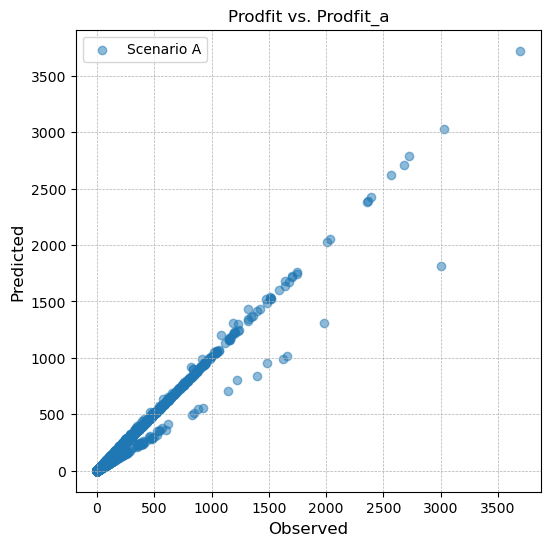

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))

scatter = ax.scatter(london_flows_scenarios_a['prodfit'], london_flows_scenarios_a['prodfit_a'], alpha=0.5, label='Scenario A')
ax.set_xlabel('Observed', fontsize=12)  # 设置字体大小增加可读性
ax.set_ylabel('Predicted', fontsize=12)
ax.set_title('Prodfit vs. Prodfit_a')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.savefig('profit_a.png')


plt.show()

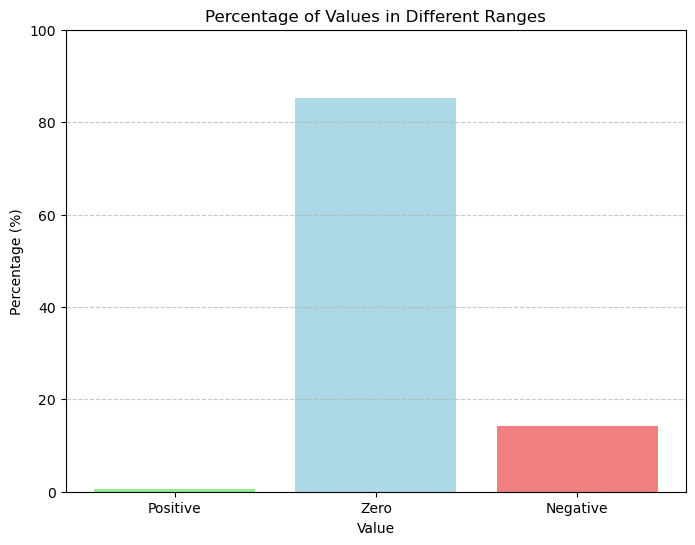

In [28]:

london_flows_scenarios_a['difference_a'] = london_flows_scenarios_a['prodfit'] - london_flows_scenarios_a['prodfit_a']


positive_percentage = (london_flows_scenarios_a['difference_a'] > 0).mean() * 100
zero_percentage = (london_flows_scenarios_a['difference_a'] == 0).mean() * 100
negative_percentage = (london_flows_scenarios_a['difference_a'] < 0).mean() * 100


labels = ['Positive', 'Zero', 'Negative']
percentages = [positive_percentage, zero_percentage, negative_percentage]

plt.figure(figsize=(8, 6))
plt.bar(labels, percentages, color=['lightgreen', 'lightblue', 'lightcoral'])
plt.xlabel('Value')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Values in Different Ranges')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)
plt.savefig('dif_a.png')
plt.show()

In [29]:
#here's the matrix
london_flows_matrix_a = london_flows_scenarios_a.pivot_table(values ="prodfit_a", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
london_flows_matrix_a 

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,597.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3750.0
Aldgate,NaN,NaN,1.0,NaN,38.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2886.0
Aldgate East,NaN,NaN,1.0,41.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,42.0,53.0,NaN,NaN,NaN,NaN,31.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4860.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3102.0


In [30]:
london_flows_matrix_fit

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100.0


# B

In [31]:
#double increase

beta_1 = beta*2

In [32]:
#calculate some new wj^alpha and d_ij^beta values
Dj_b1_gamma = london_flows_scenarios_a["jobs"]**gamma

dist_beta_b1 =np.exp(london_flows_scenarios_a["distance"]*(-beta_1))

#calcualte the Ai values
london_flows_scenarios_a["A_ib1"] = Dj_b1_gamma * dist_beta_b1

#now do the sum over all js bit
A_ib1 = pd.DataFrame(london_flows_scenarios_a.groupby(["station_origin"])["A_ib1"].agg(np.sum))

#now divide into 1
A_ib1["A_ib1"] = 1/A_ib1["A_ib1"]
A_ib1.rename(columns={"A_ib1":"A_i_b1"}, inplace=True)

#and write the A_i values back into the dataframe
london_flows_scenarios_a = london_flows_scenarios_a.merge(A_ib1, left_on="station_origin", right_index=True, how="left")

london_flows_scenarios_a.head()

,station_origin,station_destination,flows,population,jobs,distance,log_dest_jobs,log_distance,fit1,fit2,...,prodfit,Dj_jobs,A_ia,A_i_a,prodfit_a,log_flows_profit,log_flows_scenario_a,difference_a,A_ib1,A_i_b1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,55.0,78.0,...,78.0,78549.0,1432.231104,0.000097,83.0,4.356722,4.418853,-5.0,412.202187,0.00015
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,1.0,1.0,...,1.0,442.0,27.026714,0.000097,2.0,0.001000,0.693647,-1.0,7.340176,0.00015
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,3.0,4.0,...,4.0,665.0,75.982904,0.000097,4.0,1.386544,1.386544,0.0,42.616318,0.00015
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,66.0,99.0,...,99.0,29386.0,1086.638601,0.000097,63.0,4.595130,4.143151,36.0,841.547158,0.00015
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,49.0,56.0,...,56.0,15428.0,1034.750388,0.000097,60.0,4.025370,4.094361,-4.0,735.477412,0.00015


In [33]:
#to check everything works, recreate the original estimates
london_flows_scenarios_a["prodfit_b1"] = london_flows_scenarios_a["A_i_b1"]*london_flows_scenarios_a["population"]*Dj_b1_gamma*dist_beta_b1
#round
london_flows_scenarios_a["prodfit_b1"] = round(london_flows_scenarios_a["prodfit_b1"])

In [34]:
#here's the matrix
london_flows_matrix_b1 = london_flows_scenarios_a.pivot_table(values ="prodfit_b1", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)

london_flows_matrix_b1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,4.0,4.0,NaN,26.0,0.0,NaN,6.0,...,5.0,1.0,0.0,30.0,NaN,0.0,NaN,0.0,NaN,3728.0
Aldgate,NaN,NaN,0.0,NaN,56.0,NaN,NaN,0.0,NaN,30.0,...,0.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2875.0
Aldgate East,NaN,NaN,0.0,61.0,NaN,NaN,0.0,0.0,NaN,31.0,...,0.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,26.0,40.0,NaN,NaN,NaN,NaN,14.0,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4863.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,0.0,11.0,10.0,NaN,0.0,NaN,NaN,28.0,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3087.0


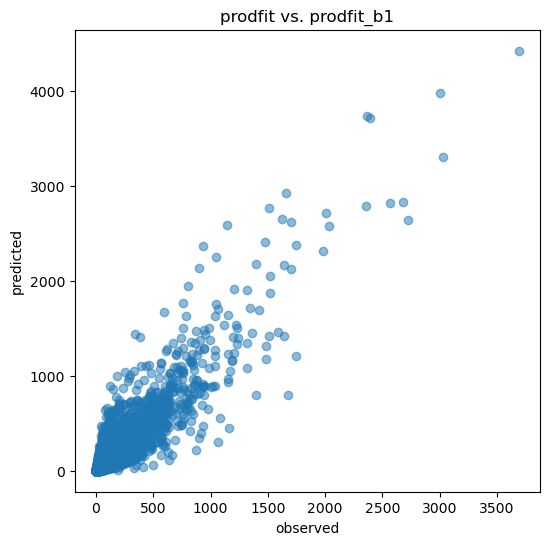

In [35]:
plt.figure(figsize=(6, 6))  
plt.scatter(london_flows_scenarios_a['prodfit'], london_flows_scenarios_a['prodfit_b1'], alpha=0.5)
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('prodfit vs. prodfit_b1')
plt.savefig('profit_b1.png')
plt.show()  

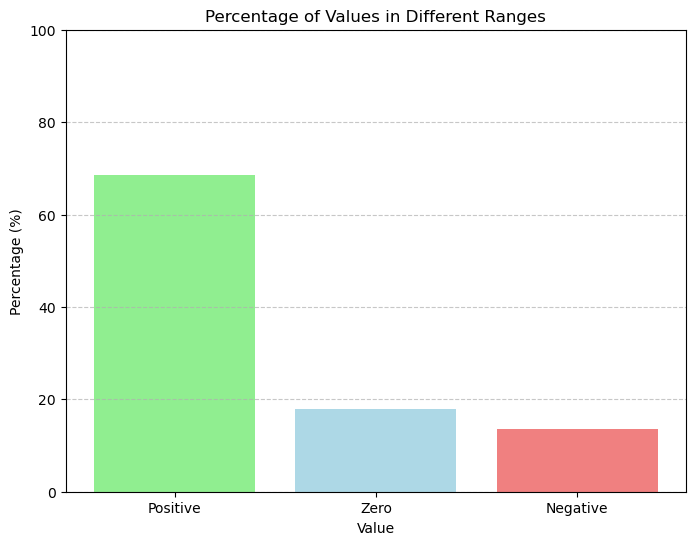

In [36]:
london_flows_scenarios_a['difference_b1'] = london_flows_scenarios_a['prodfit'] - london_flows_scenarios_a['prodfit_b1']

positive_percentage = (london_flows_scenarios_a['difference_b1'] > 0).mean() * 100
zero_percentage = (london_flows_scenarios_a['difference_b1'] == 0).mean() * 100
negative_percentage = (london_flows_scenarios_a['difference_b1'] < 0).mean() * 100

labels = ['Positive', 'Zero', 'Negative']
percentages = [positive_percentage, zero_percentage, negative_percentage]

plt.figure(figsize=(8, 6))
plt.bar(labels, percentages, color=['lightgreen', 'lightblue', 'lightcoral'])
plt.xlabel('Value')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Values in Different Ranges')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)
plt.savefig('dif_b1.png')
plt.show()

In [37]:
#strong increase

beta_2 = beta*10

In [38]:

#calculate some new wj^alpha and d_ij^beta values
Dj_b2_gamma = london_flows_scenarios_a["jobs"]**gamma

dist_beta_b2 =np.exp(london_flows_scenarios_a["distance"]*(-beta_2))

#calcualte the Ai values
london_flows_scenarios_a["A_ib2"] = Dj_b2_gamma * dist_beta_b2

#now do the sum over all js bit
A_ib2 = pd.DataFrame(london_flows_scenarios_a.groupby(["station_origin"])["A_ib2"].agg(np.sum))

#now divide into 1
A_ib2["A_ib2"] = 1/A_ib2["A_ib2"]
A_ib2.rename(columns={"A_ib2":"A_i_b2"}, inplace=True)

#and write the A_i values back into the dataframe
london_flows_scenarios_a = london_flows_scenarios_a.merge(A_ib2, left_on="station_origin", right_index=True, how="left")

In [39]:
#to check everything works, recreate the original estimates
london_flows_scenarios_a["prodfit_b2"] = london_flows_scenarios_a["A_i_b2"]*london_flows_scenarios_a["population"]*Dj_b2_gamma*dist_beta_b2
#round
london_flows_scenarios_a["prodfit_b2"] = round(london_flows_scenarios_a["prodfit_b2"])

In [40]:
london_flows_scenarios_a.head()

,station_origin,station_destination,flows,population,jobs,distance,log_dest_jobs,log_distance,fit1,fit2,...,log_flows_profit,log_flows_scenario_a,difference_a,A_ib1,A_i_b1,prodfit_b1,difference_b1,A_ib2,A_i_b2,prodfit_b2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,55.0,78.0,...,4.356722,4.418853,-5.0,412.202187,0.00015,37.0,41.0,0.019404,0.000935,0.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,1.0,1.0,...,0.001000,0.693647,-1.0,7.340176,0.00015,1.0,0.0,0.000217,0.000935,0.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,3.0,4.0,...,1.386544,1.386544,0.0,42.616318,0.00015,4.0,0.0,0.417308,0.000935,0.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,66.0,99.0,...,4.595130,4.143151,36.0,841.547158,0.00015,76.0,23.0,1.652990,0.000935,1.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,49.0,56.0,...,4.025370,4.094361,-4.0,735.477412,0.00015,66.0,-10.0,47.911445,0.000935,27.0


In [41]:
#here's the matrix
london_flows_matrix_b2 = london_flows_scenarios_a.pivot_table(values ="prodfit_b2", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)

london_flows_matrix_b2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,2.0,0.0,NaN,0.0,...,0.0,0.0,0.0,1.0,NaN,0.0,NaN,0.0,NaN,3742.0
Aldgate,NaN,NaN,0.0,NaN,87.0,NaN,NaN,0.0,NaN,4.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,2881.0
Aldgate East,NaN,NaN,0.0,117.0,NaN,NaN,0.0,0.0,NaN,3.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


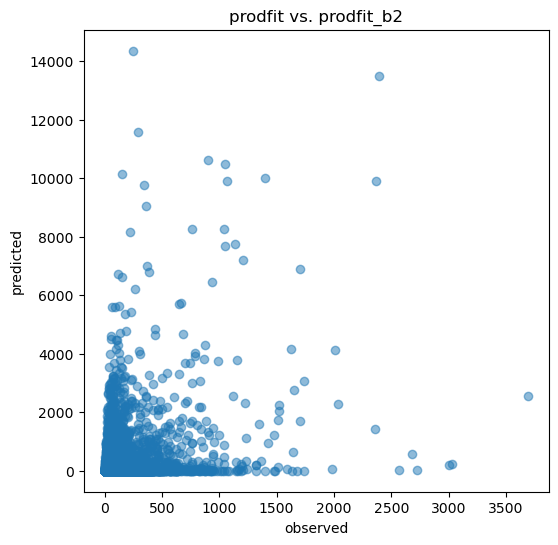

In [42]:
plt.figure(figsize=(6, 6))  
plt.scatter(london_flows_scenarios_a['prodfit'], london_flows_scenarios_a['prodfit_b2'], alpha=0.5)
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('prodfit vs. prodfit_b2')
plt.savefig('profit_b2.png')
plt.show()  

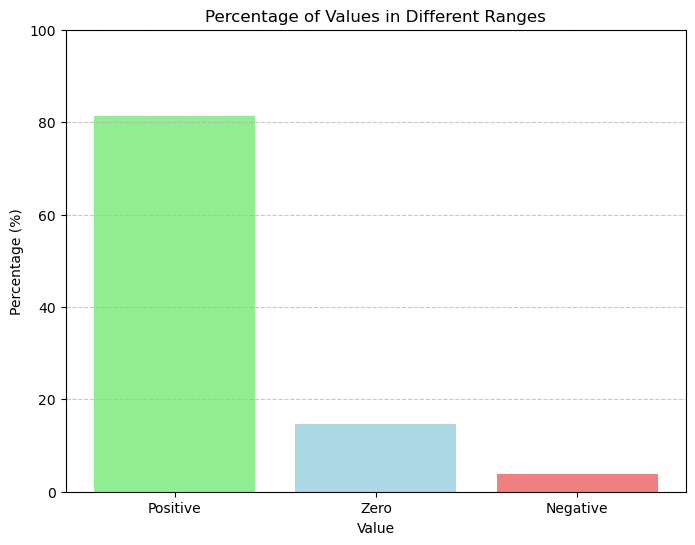

In [43]:
london_flows_scenarios_a['difference_b2'] = london_flows_scenarios_a['prodfit'] - london_flows_scenarios_a['prodfit_b2']


positive_percentage = (london_flows_scenarios_a['difference_b2'] > 0).mean() * 100
zero_percentage = (london_flows_scenarios_a['difference_b2'] == 0).mean() * 100
negative_percentage = (london_flows_scenarios_a['difference_b2'] < 0).mean() * 100


labels = ['Positive', 'Zero', 'Negative']
percentages = [positive_percentage, zero_percentage, negative_percentage]

plt.figure(figsize=(8, 6))
plt.bar(labels, percentages, color=['lightgreen', 'lightblue', 'lightcoral'])
plt.xlabel('Value')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Values in Different Ranges')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)
plt.savefig('dif_b2.png')
plt.show()

In [44]:
#check all
london_flows_scenarios_a[["station_origin","station_destination", "prodfit", "prodfit_a","prodfit_b1","prodfit_b2"]]

,station_origin,station_destination,prodfit,prodfit_a,prodfit_b1,prodfit_b2
0,Abbey Road,Bank and Monument,78.0,83.0,37.0,0.0
1,Abbey Road,Beckton,1.0,2.0,1.0,0.0
2,Abbey Road,Blackwall,4.0,4.0,4.0,0.0
3,Abbey Road,Canary Wharf,99.0,63.0,76.0,1.0
4,Abbey Road,Canning Town,56.0,60.0,66.0,27.0
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,99.0,107.0,51.0,0.0
61470,Woolwich Arsenal,West Ham,295.0,320.0,312.0,2.0
61471,Woolwich Arsenal,West India Quay,36.0,39.0,33.0,0.0
61472,Woolwich Arsenal,West Silvertown,125.0,135.0,221.0,66.0


In [45]:
Total = london_flows_scenarios_a.groupby('station_origin')[['prodfit', 'prodfit_a', 'prodfit_b1', 'prodfit_b2']].sum()

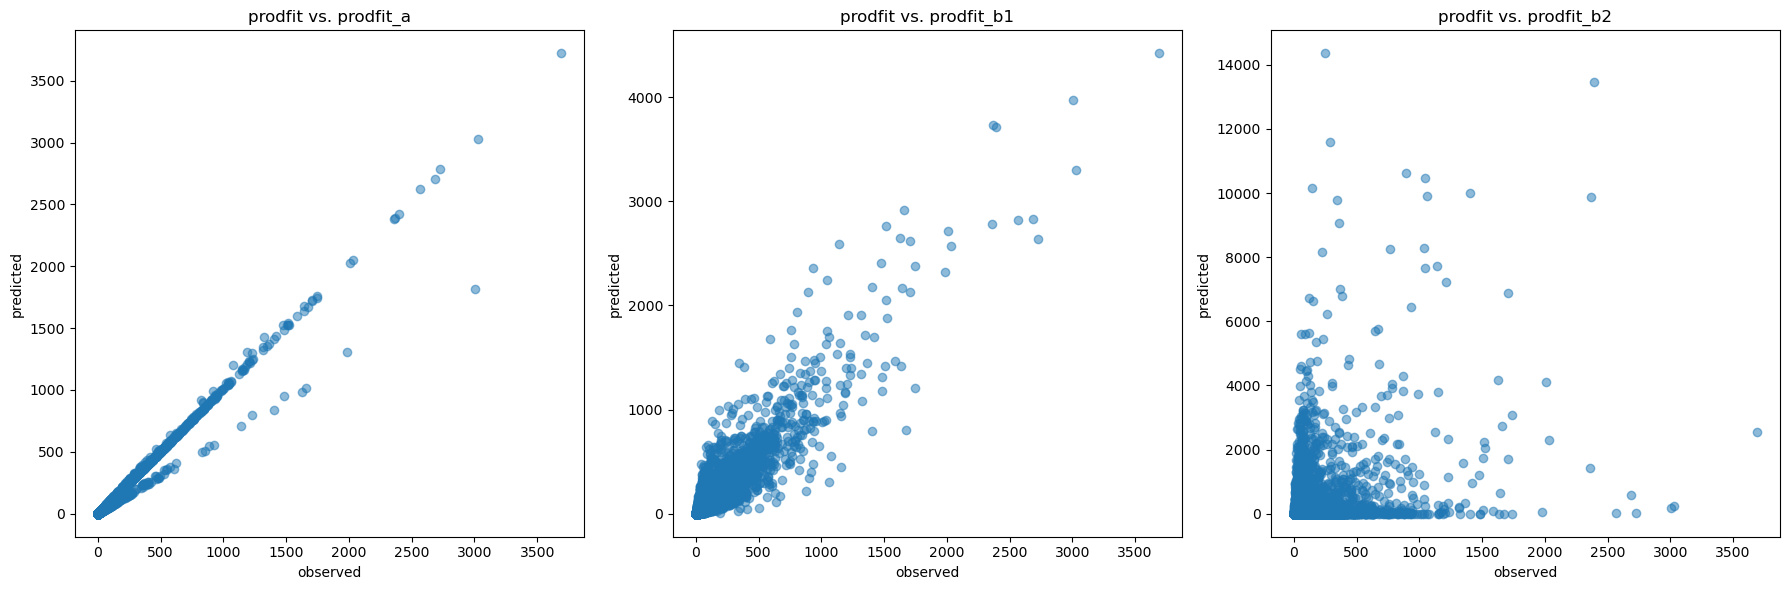

In [46]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))


axes[0].scatter(london_flows_scenarios_a['prodfit'], london_flows_scenarios_a['prodfit_a'], alpha=0.5)
axes[0].set_xlabel('observed')
axes[0].set_ylabel('predicted')
axes[0].set_title('prodfit vs. prodfit_a')


axes[1].scatter(london_flows_scenarios_a['prodfit'], london_flows_scenarios_a['prodfit_b1'], alpha=0.5)
axes[1].set_xlabel('observed')
axes[1].set_ylabel('predicted')
axes[1].set_title('prodfit vs. prodfit_b1')

axes[2].scatter(london_flows_scenarios_a['prodfit'], london_flows_scenarios_a['prodfit_b2'], alpha=0.5)
axes[2].set_xlabel('observed')
axes[2].set_ylabel('predicted')
axes[2].set_title('prodfit vs. prodfit_b2')


plt.tight_layout()

plt.savefig('profit_vs.png')

plt.show()

In [47]:
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', None)  

# 显示DataFrame
print(Total)

                             prodfit  prodfit_a  prodfit_b1  prodfit_b2
station_origin                                                         
Abbey Road                     595.0      597.0       599.0       599.0
Acton Central                 1226.0     1226.0      1224.0      1224.0
Acton Town                    3744.0     3750.0      3728.0      3742.0
Aldgate                       2885.0     2886.0      2875.0      2881.0
Aldgate East                  3160.0     3167.0      3167.0      3167.0
All Saints                     739.0      738.0       742.0       739.0
Alperton                      1627.0     1625.0      1620.0      1623.0
Amersham                      1190.0     1191.0      1184.0      1190.0
Anerley                        641.0      641.0       644.0       643.0
Angel                         4192.0     4189.0      4196.0      4194.0
Archway                       5644.0     5637.0      5638.0      5637.0
Arnos Grove                   3048.0     3045.0      3050.0     